# Fraud Detection Model Development and Evaluation with Computer Vision Techniques

***import necessay packages and libraries***

In [1]:
import pandas as pd
import os
import cv2  # OpenCV library for image processing
import matplotlib.pyplot as plt

In [2]:
# Dataset Extraction from local directory
df=pd.read_csv('train/train.csv')
df.head()

,image_id,filename,label
0,1,1.jpg,0
1,2,2.jpg,0
2,3,3.jpg,0
3,4,4.jpg,0
4,5,5.jpg,0


In [3]:
df['label'].value_counts()

label
0    7614
1     465
Name: count, dtype: int64

***Class Distribution***

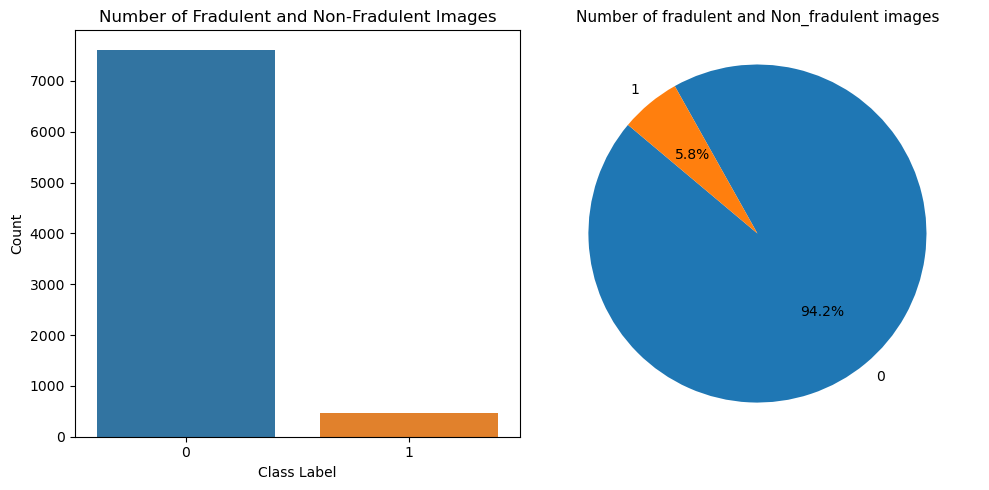

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate counts of each class
class_counts = df['label'].value_counts()

# Plot using seaborn
plt.figure(figsize=(10, 5))

# Bar plot
plt.subplot(1, 2, 1)
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Number of Fradulent and Non-Fradulent Images")
plt.xlabel("Class Label")
plt.ylabel("Count")

# Pie plot
plt.subplot(1, 2, 2)
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Number of fradulent and Non_fradulent images", fontsize=11)
plt.axis('equal')

plt.tight_layout()
plt.show()


***Here I splitted the images into frdadulent and non-fradulent folder***

In [6]:
import os
import shutil

# Define source and destination directories
source_dir = 'train/images'  # Directory containing all images
fradulent_dir = 'images/fradulent'  # Directory where images will be saved based on their labels
non_fradulent_dir = 'images/non-fradulent'  # Directory where images will be saved based on their labels
os.makedirs('images', exist_ok=True)
# Iterate through the DataFrame
for index, row in df.iterrows():
    filename = row['filename']
    label = row['label']
    if label==1:
        # Move image to the corresponding label directory
        os.makedirs(fradulent_dir, exist_ok=True)
        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(fradulent_dir, filename)
        shutil.copy(src_path, dst_path)
    else:
        # Move image to the corresponding label directory
        os.makedirs(non_fradulent_dir, exist_ok=True)
        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(non_fradulent_dir, filename)
        shutil.copy(src_path, dst_path)


***Apply Image Augumentation technique for balancing the fradulent and non-fradulent images***

In [10]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Path where all images are stored in our directory
directory_path = 'images/fraudulent'

# Function to load images from directory
def load_images_from_directory(directory_path):
    images = []
    # Get list of filenames in the directory
    filenames = os.listdir(directory_path)
    for filename in filenames:
        image_path = os.path.join(directory_path, filename)
        image = cv2.imread(image_path)
        # Resize all images into the same size
        image = cv2.resize(image, (128, 128))
        images.append(image)
    return images, filenames

# Load images and filenames from directory
fraudulent_images, fraudulent_filenames = load_images_from_directory(directory_path)

# Define augumentation directory for augmented images
augmented_dir = 'augmented_images'
fraudulent_augmented_dir = os.path.join(augmented_dir, 'fraudulent')

# Create directory if it doesn't exist
os.makedirs(fraudulent_augmented_dir, exist_ok=True)

# Augment and save fraudulent images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

for idx, image in enumerate(fraudulent_images):
    # Expand dimensions to match expected input shape for ImageDataGenerator
    image = np.expand_dims(image, axis=0)
    # Generate augmented images
    for idx2, batch in enumerate(datagen.flow(image, batch_size=1)):
        augmented_image = batch[0].astype(np.uint8)
        augmented_image_path = os.path.join(fraudulent_augmented_dir, f"{os.path.splitext(fraudulent_filenames[idx])[0]}_{idx2}.jpg")
        # Save augmented image
        cv2.imwrite(augmented_image_path, augmented_image)
        # Break after generating desired number of augmented images
        if idx2 == 15:  # Define how many augmented images you want per original image
            break


***Splitting Fradulent and Non-fradulent images into training, testing and validation with the size of 60:20:20 ratio***

In [19]:
import os

# Define directory paths
base_dir = 'images'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

# Define subfolder names
fraudulent_folder = 'fraudulent '
non_fraudulent_folder = 'non-fraudulent'

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Create subdirectories for train, test, and validation sets
for folder in [train_dir, test_dir, validation_dir]:
    os.makedirs(os.path.join(folder, fraudulent_folder), exist_ok=True)
    os.makedirs(os.path.join(folder, non_fraudulent_folder), exist_ok=True)


In [21]:
import os
import shutil
import random

# Define subfolder names
fraudulent_dir = 'images/fraudulent'
non_fraudulent_dir = 'images/non-fraudulent'

# Define function to split images into train, test, and validation sets
def split_data(source, train, test, validation, split_size):
    files = []
    for filename in os.listdir(source):
        file = os.path.join(source, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    
    # Shuffle files to ensure randomness
    random.shuffle(files)
    
    # Split files into train, test, and validation sets
    train_size = int(len(files) * split_size[0])
    test_size = int(len(files) * split_size[1])
    validation_size = int(len(files) * split_size[2])
    
    train_files = files[:train_size]
    test_files = files[train_size:train_size+test_size]
    validation_files = files[train_size+test_size:]
    
    # Split testing set further into testing and validation
    test_split = int(len(test_files) * 0.2)
    validation_files.extend(test_files[:test_split])
    test_files = test_files[test_split:]
    
    # Copy files to respective directories
    for filename in train_files:
        shutil.copy(os.path.join(source, filename), os.path.join(train, filename))
    for filename in test_files:
        shutil.copy(os.path.join(source, filename), os.path.join(test, filename))
    for filename in validation_files:
        shutil.copy(os.path.join(source, filename), os.path.join(validation, filename))

# Define split sizes
split_size = (0.7, 0.15, 0.15)

# Split fraudulent images into train, test, and validation sets
split_data(fraudulent_dir, 'images/train/fraudulent', 'images/test/fraudulent', 'images/validation/fraudulent', split_size)

# Split non-fraudulent images into train, test, and validation sets
split_data(non_fraudulent_dir, 'images/train/non-fraudulent', 'images/test/non-fraudulent', 'images/validation/non-fraudulent', split_size)


***Setup data generators for efficiently loading and preprocessing images from train,val and test directories for training and testing a neural network model***

In [34]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
train_data = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=.20,
    zoom_range=0.2,
    fill_mode="nearest",
    brightness_range=[0.5, 1.0]
)

test_data = ImageDataGenerator(
    rescale=1./225,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    brightness_range=[0.5, 1.0]
)

In [35]:
train_gen = train_data.flow_from_directory(
    'images2/train',
    target_size=(128, 128),
    batch_size=64,
    class_mode="binary",classes=['non-fraudulent','fraudulent']
)

val_gen = test_data.flow_from_directory(
    'images2/validation',
    target_size=(128, 128),
    batch_size=64,
    class_mode="binary",classes=['non-fraudulent','fraudulent']
)

Found 10862 images belonging to 2 classes.
Found 2795 images belonging to 2 classes.


In [36]:
# Get the class indices
class_indices = train_gen.class_indices

# Print the class indices
print("Class Indices:", class_indices)


Class Indices: {'non-fraudulent': 0, 'fraudulent': 1}


***Get the testing data and class***

In [64]:
import cv2
import os

test_data_dir = 'images2/test'  # test directory path
image_size = (128, 128)  # Desired image size
data = []
labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    if os.path.isdir(class_dir):
        # Define the label based on the class name
        label = 1 if class_name == 'fraudulent' else 0
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            # Read the image using OpenCV
            img_array = cv2.imread(image_path)
            # Resize the image
            img_array = cv2.resize(img_array, image_size)
            # Append the image and label to data and labels lists
            data.append(img_array)
            labels.append(label)

In [65]:
import numpy as np
# Convert lists to numpy arrays
test_data1 = np.array(data)
labels = np.array(labels)

In [66]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [67]:
test_data_1 = test_data1.astype('float32') / 255.0  # Normalize the test data

In [68]:
test_data_1.shape

(1862, 128, 128, 3)

**To Build CNN model for classification**

In [9]:
# Model architecture
import tensorflow as tf
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu", 
                               input_shape=(128, 128, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)       

In [10]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10


169/169 [==============================] - 376s 2s/step - loss: 0.6481 - accuracy: 0.6258 - precision: 0.6281 - recall: 0.6493 - val_loss: 0.5929 - val_accuracy: 0.6915 - val_precision: 0.7124 - val_recall: 0.6600
Epoch 2/10
169/169 [==============================] - 187s 1s/step - loss: 0.5867 - accuracy: 0.6948 - precision: 0.7137 - recall: 0.6696 - val_loss: 0.5420 - val_accuracy: 0.7253 - val_precision: 0.7566 - val_recall: 0.6776
Epoch 3/10
169/169 [==============================] - 189s 1s/step - loss: 0.5244 - accuracy: 0.7406 - precision: 0.7624 - recall: 0.7123 - val_loss: 0.6269 - val_accuracy: 0.6679 - val_precision: 0.6122 - val_recall: 0.9537
Epoch 4/10
169/169 [==============================] - 198s 1s/step - loss: 0.4341 - accuracy: 0.8018 - precision: 0.8172 - recall: 0.7860 - val_loss: 0.3827 - val_accuracy: 0.8459 - val_precision: 0.9479 - val_recall: 0.7386
Epoch 5/10
169/169 [==============================] - 194s 1s/step - loss: 0.3905 - accuracy: 0.82

In [72]:
# Evaluate the model
test_gen = test_data.flow_from_directory(
    'images2/test',
    target_size=(128, 128),
    batch_size=64,
    class_mode="binary",classes=['non-fraudulent','fraudulent']
)

evaluation = model.evaluate(test_gen)
print("Test Accuracy:", evaluation[1])
print("Test Precision:", evaluation[2])
print("Test Recall:", evaluation[3])
print("Test Loss:", evaluation[0])

Found 1862 images belonging to 2 classes.
30/30 [==============================] - 18s 593ms/step - loss: 0.2255 - accuracy: 0.9125 - precision: 0.9395 - recall: 0.8850
Test Accuracy: 0.9124597311019897
Test Precision: 0.9395296573638916
Test Recall: 0.8850210905075073
Test Loss: 0.22549013793468475


In [73]:
#Save the model in our directory
model.save('CNN_Model_1.h5')

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


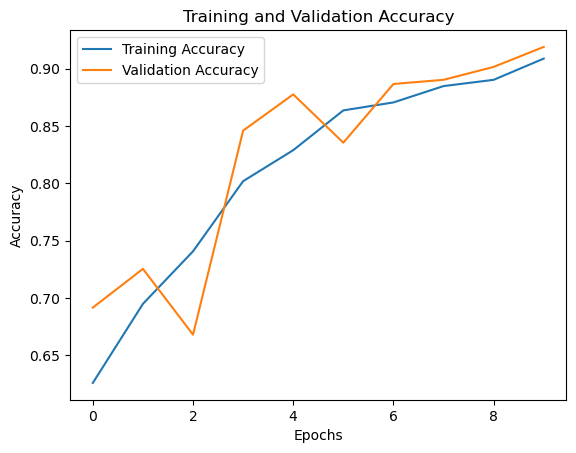

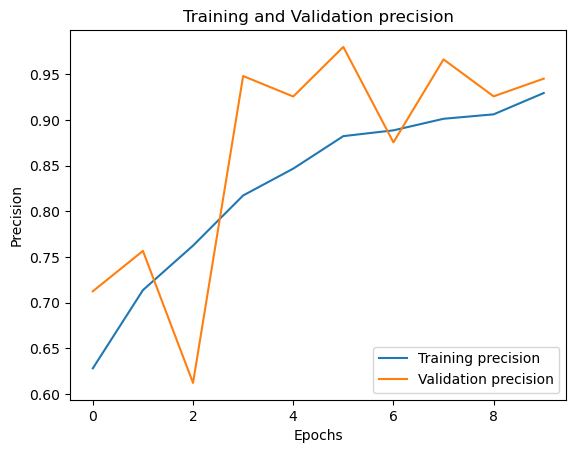

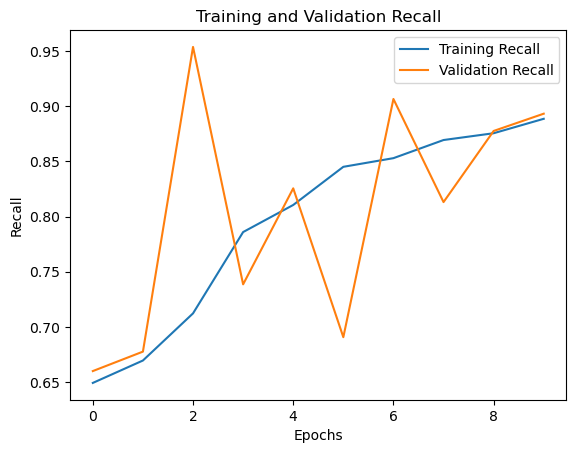

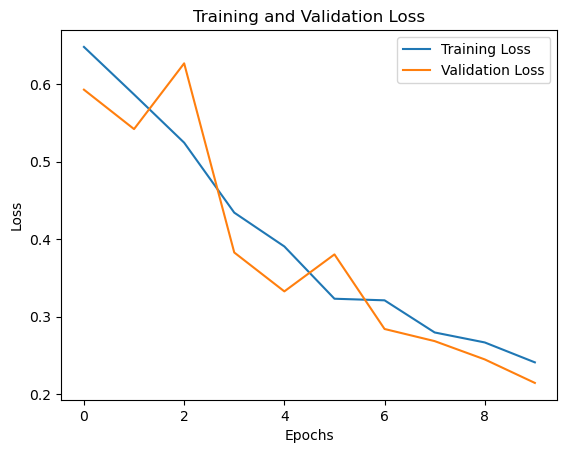

In [74]:
# Plot training and validation accuracy values over the number of epoochs
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
plt.plot(history.history['precision'], label='Training precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()


import matplotlib.pyplot as plt
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


# Plot training and validation loss values over the number of epoochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

***Model Prediction***

In [117]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model=load_model('CNN_Model_1.h5')
def predict_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128,128))   #Resize the original image into (128,128) shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape expected by the model

    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"  # Here we did binary classification with a threshold of 0.5

    return predicted_class


image_path = "train/images/2.jpg"  # Provide the path to our input image
prediction = predict_image(image_path, model)
print("Prediction:", prediction)


1/1 [==============================] - 0s 78ms/step
Prediction: non-fraudulent


In [118]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model=load_model('CNN_Model_1.h5')
def predict_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128,128,3))  # Provide your target size here
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape expected by the model
    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"  #binary classification with a threshold of 0.5

    return predicted_class

# Example usage:
image_path = "train/images/7501.jpg"  # Provide the path to your image
prediction = predict_image(image_path, model)
print("Prediction:", prediction)


1/1 [==============================] - 0s 78ms/step
Prediction: fraudulent


***Create webframework using Gradio***

In [24]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model = load_model('model1.h5')

# Define function to predict image class
def predict_image(image_file):
    # Load and preprocess the image
    img = image.load_img(image_file.name, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"
    return predicted_class

# Create a Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs="image",  # Here we give input as image
    outputs="text",  # We will return the predicted class as output
    title="Image Fraud Detection Model",  # Interface title
    description="Upload an image to process.",
)

# Launch the interface
interface.launch()


Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 129ms/step
The model predicted that this image belongs to a non-fraudulent class.


**Image classification using Transfer learning Model**

In [91]:
from tensorflow.keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout
INPUT_SHAPE=(128,128,3)
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
VGG16_model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
VGG16_model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [92]:
# Train the model using training data with 5 epochs and certain batch size
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = VGG16_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=5,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/5
169/169 [==============================] - 324s 2s/step - loss: 0.4452 - accuracy: 0.7949 - precision_1: 0.8022 - recall_1: 0.7930 - val_loss: 0.3265 - val_accuracy: 0.8688 - val_precision_1: 0.9147 - val_recall_1: 0.8188
Epoch 2/5
169/169 [==============================] - 324s 2s/step - loss: 0.3335 - accuracy: 0.8546 - precision_1: 0.8595 - recall_1: 0.8542 - val_loss: 0.2906 - val_accuracy: 0.8837 - val_precision_1: 0.8655 - val_recall_1: 0.9126
Epoch 3/5
169/169 [==============================] - 338s 2s/step - loss: 0.3137 - accuracy: 0.8679 - precision_1: 0.8710 - recall_1: 0.8697 - val_loss: 0.2901 - val_accuracy: 0.8783 - val_precision_1: 0.9414 - val_recall_1: 0.8120
Epoch 4/5
169/169 [==============================] - 333s 2s/step - loss: 0.2961 - accuracy: 0.8761 - precision_1: 0.8760 - recall_1: 0.8814 - val_loss: 0.2586 - val_accuracy: 0.8899 - val_precision_1: 0.8900 - val_recall_1: 0.8944
Epoch 5/5
169/169 [==============================] - 330s 2s/step - loss

In [93]:
# Evaluate the model
test_gen = test_data.flow_from_directory(
    'images2/test',
    target_size=(128, 128),
    batch_size=64,
    class_mode="binary",classes=['non-fraudulent','fraudulent']
)

evaluation = VGG16_model.evaluate(test_gen)
print("Test Accuracy:", evaluation[1])
print("Test Precision:", evaluation[2])
print("Test Recall:", evaluation[3])
print("Test Loss:", evaluation[0])

Found 1862 images belonging to 2 classes.
30/30 [==============================] - 45s 1s/step - loss: 0.2752 - accuracy: 0.8883 - precision_1: 0.8364 - recall_1: 0.9705
Test Accuracy: 0.888292133808136
Test Precision: 0.8363636136054993
Test Recall: 0.9704641103744507
Test Loss: 0.2752290964126587


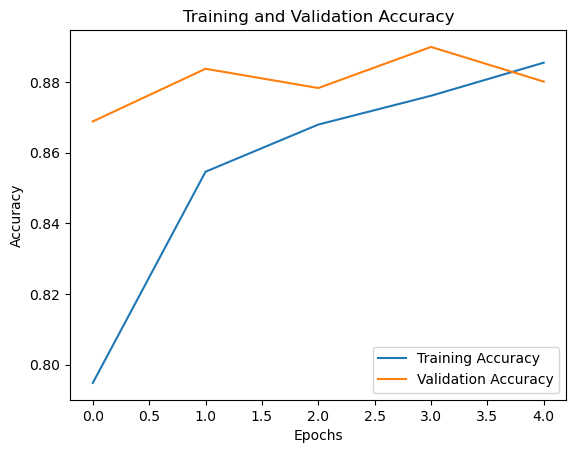

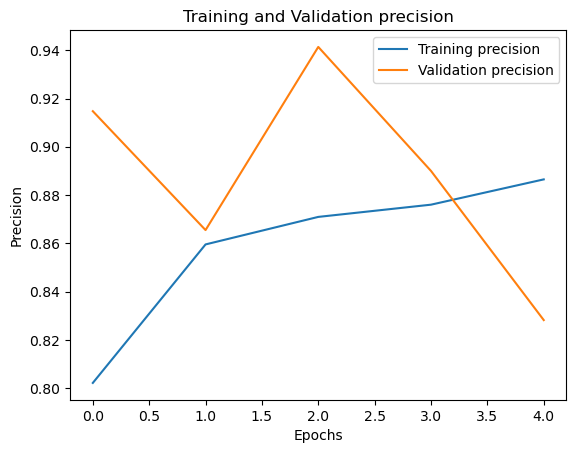

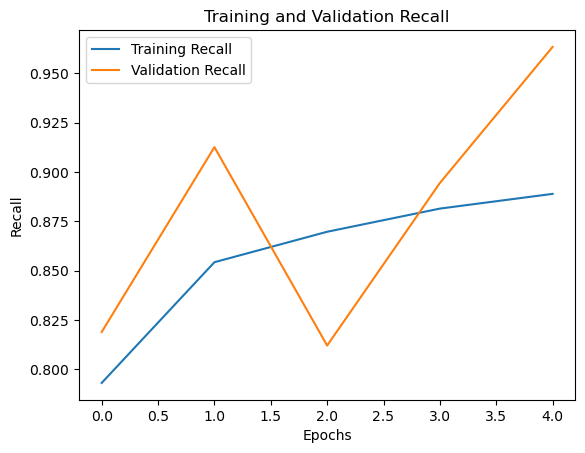

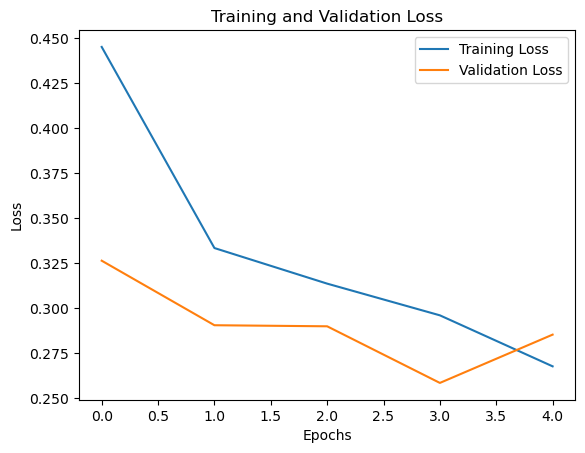

In [96]:
# Plot training and validation accuracy values over the number of epoochs
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

import matplotlib.pyplot as plt
plt.plot(history.history['precision_1'], label='Training precision')
plt.plot(history.history['val_precision_1'], label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()


import matplotlib.pyplot as plt
plt.plot(history.history['recall_1'], label='Training Recall')
plt.plot(history.history['val_recall_1'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


# Plot training and validation loss values over the number of epoochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [97]:
VGG16_model.save('VGG16_model.h5')

In [98]:
import numpy as np
preds = VGG16_model.predict(test_data_1)
predicted_labels  = np.round(preds)
predicted_labels=predicted_labels.flatten()

59/59 [==============================] - 40s 674ms/step


In [99]:
predicted_labels

array([1., 1., 1., ..., 0., 1., 0.], dtype=float32)

In [100]:
labels

array([1, 1, 1, ..., 0, 0, 0])

***Performance Metrics of the Model***

In [101]:
y_true=labels
y_pred=predicted_labels

In [102]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,classification_report,f1_score
print('Classification Report')
print(classification_report(y_true,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       914
           1       0.96      0.90      0.93       948

    accuracy                           0.93      1862
   macro avg       0.93      0.93      0.93      1862
weighted avg       0.93      0.93      0.93      1862



confusion matrix:


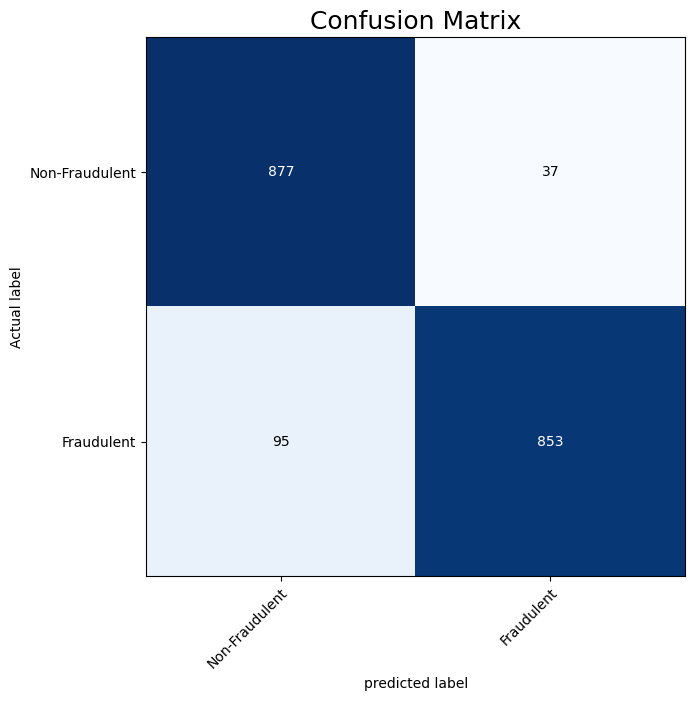

In [103]:
print("confusion matrix:")
from sklearn import metrics
import numpy as np
import seaborn as sns
conf_matrix = confusion_matrix(y_true,y_pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(7, 7), cmap=plt.cm.Blues,class_names=['Non-Fraudulent','Fraudulent'])
plt.ylabel('Actual label', fontsize=10)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [104]:
# Compute performance metrics on test set
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true,y_pred)
recall = recall_score(y_true,y_pred)
f1 = f1_score(y_true,y_pred)
conf_matrix = confusion_matrix(y_true,y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9291084854994629
Precision: 0.9584269662921349
Recall: 0.8997890295358649
F1-score: 0.9281828073993471


***Model Prediction***

In [105]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Load the trained model
model=load_model('VGG16_model.h5')
def predict_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128,128))   #Resize the original image into (128,128) shape
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape expected by the model

    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"  # Here we did binary classification with a threshold of 0.5

    return predicted_class


image_path = "train/images/2.jpg"  # Provide the path to our input image
prediction = predict_image(image_path, model)
print("Prediction:", prediction)


1/1 [==============================] - 0s 190ms/step
Prediction: non-fraudulent


In [110]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Load the trained model
def predict_image(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(128,128,3))  # Provide your target size here
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the input shape expected by the model
    # Predict the class of the image
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"  #binary classification with a threshold of 0.5

    return predicted_class

# Example usage:
image_path = "train/images/142.jpg"  # Provide the path to your image
prediction = predict_image(image_path, model)
print("Prediction:", prediction)


1/1 [==============================] - 0s 56ms/step
Prediction: fraudulent


***Create webframework using Gradio***

In [111]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing import image
from keras.models import load_model

# Define function to predict image class
def predict_image(image_file):
    # Load and preprocess the image
    img = image.load_img(image_file.name, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = "fraudulent" if prediction > 0.5 else "non-fraudulent"
    return predicted_class

# Create a Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs="image",  # Here we give input as image
    outputs="text",  # We will return the predicted class as output
    title="Image Fraud Detection Model",  # Interface title
    description="Upload an image to process.",
)

# Launch the interface
interface.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
